In [1]:
using Revise

using Langevin
using Langevin.Preconditioners: MatrixMOp, BlockPreconditioner, FourierPreconditioner

using LinearAlgebra
using IterativeSolvers
using SparseArrays
using Random

using BenchmarkTools

import Serialization
# holstein = Serialization.deserialize("holstein_6x6_cond106.dat")
holstein = Serialization.deserialize("holstein_6x6_cdw.dat")

M = Array(Langevin.HolsteinModels.construct_M(holstein))
M_op = MatrixMOp(holstein)
P_op = BlockPreconditioner(holstein, subtol=1e-2)
PF_op = FourierPreconditioner(holstein)

L = holstein.Lτ
N = holstein.nsites
;

In [2]:
# original
expnΔτV_orig = copy(holstein.expnΔτV)

# average over tau
expnΔτV_block = dropdims(sum(reshape(holstein.expnΔτV, (L, N)); dims=1) / L; dims=1)

# average over tau and x
expnΔτV_scalar = sum(expnΔτV_orig) / (L*N)
;

In [3]:
# original holstein matrix
M = Array(Langevin.HolsteinModels.construct_M(holstein))

# block preconditioner
b = reshape(holstein.expnΔτV, (L, N))
for τ = 1:L
   @. b[τ, :] = expnΔτV_block
end
P_block = Array(Langevin.HolsteinModels.construct_M(holstein))

# fourier preconditioner
holstein.expnΔτV .= expnΔτV_scalar
P_fourier = Array(Langevin.HolsteinModels.construct_M(holstein))
;

## Ability of preconditioners to reduce condition number

In [4]:
cond(M)

91.15039671895502

In [5]:
cond(P_fourier \ M)

25.135218153555698

In [6]:
cond(M / P_fourier)

24.020330356938448

In [7]:
cond(P_block \ M)

11.47691695743408

In [8]:
cond(M / P_block)

11.185777210643481

##  Affect on spectrum

In [9]:
using Plots

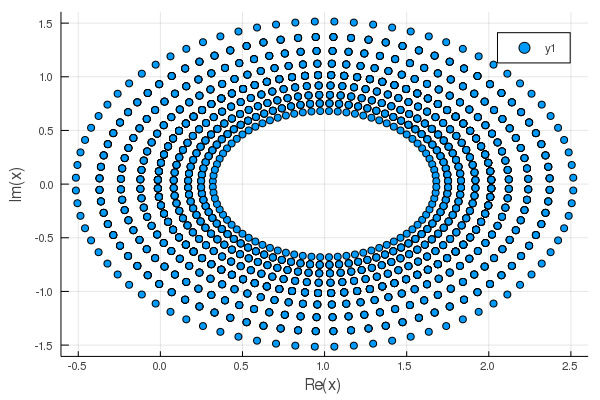

In [10]:
scatter(eigvals(P_fourier), fmt = :png)

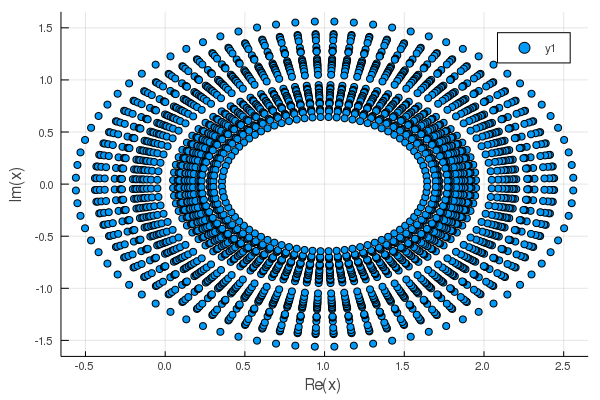

In [11]:
scatter(eigvals(M), fmt = :png)

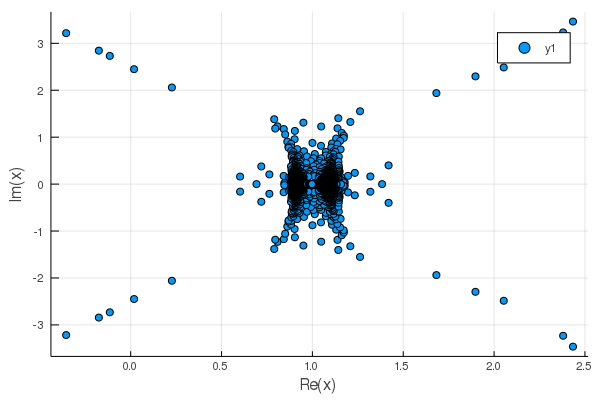

In [12]:
scatter(eigvals(P_fourier \ M), fmt = :png)

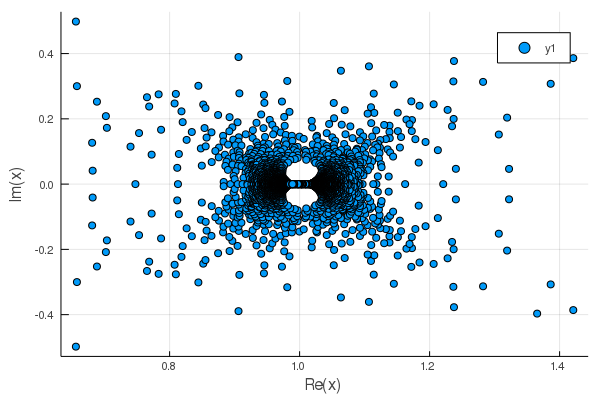

In [13]:
scatter(eigvals(P_block \ M), fmt = :png)

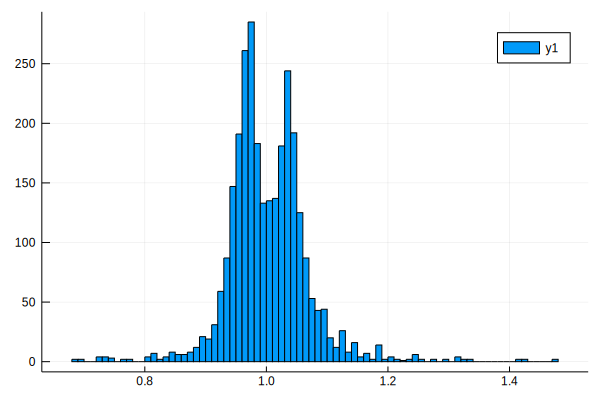

In [14]:
A = P_block \ M
histogram(abs.(eigvals(A)))

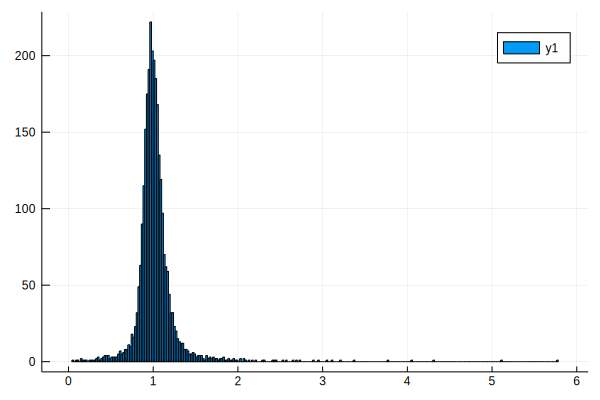

In [15]:
A = P_block \ M
histogram(eigvals(A * A'))

## Ability of preconditioners to cancel matrix elements

### All elements

In [16]:
# stddev of all matrix elements
norm(inv(M)) / (L*N) # == sqrt(tr(inv(M) * inv(M)')) / (L*N)

0.037696552089847

In [17]:
norm(inv(M) - inv(P_fourier)) / (L*N)

0.041085822082529005

In [18]:
norm(inv(M) - inv(P_block)) / (L*N)

0.016605031870724797

### Diagonal only

In [19]:
# stddev of diagonal elements
norm(diag(inv(M))) / sqrt(L*N)

0.5908235834608623

In [20]:
norm(diag(inv(M)-inv(P_fourier))) / sqrt(L*N)

0.32428120267946786

In [21]:
norm(diag(inv(M)-inv(P_block))) / sqrt(L*N)

0.06479138681165712

## Ability of preconditioner to reduce stochastic error

Approximator:
$A \approx \tilde A = A r r^\dagger$

Error:
$\Delta A = \tilde A - A = A (r r^\dagger - I)$

Sample variance of error in single matrix element,
$\mathrm{Var} [\Delta A_{ij}] = (\tilde A_{ij} - A_{ij})^2$

Variance of error averaged over all matrix elements,

$\langle \mathrm{Var} [\Delta A_{ij}] \rangle = \frac{1}{L^2 N^2} \sum_{ij} (\Delta A_{ij})^2 = \frac{1}{L^2 N^2} \mathrm{norm}^2(\Delta A)$

Standard deviation of $\Delta A_{ij}$ for a "typical" element $(i,j)$ is then,

$\mathrm{Stddev} [\Delta A_{ij}] = \frac{1}{L N} \mathrm{norm}(\Delta A)$

In [22]:
Random.seed!(0)
r = randn(N*L)
;

### All elements

In [23]:
norm(inv(M) * (I - r*r')) / (L*N)

2.3057492354627973

In [24]:
norm((inv(M)-inv(P_fourier)) * (I - r*r')) / (L*N)

2.5131994969951905

In [25]:
norm((inv(M)-inv(P_block)) * (I - r*r')) / (L*N)

1.1257564316982882

### Diagonal only

In [26]:
norm(diag(inv(M) * (I - r*r'))) / sqrt(L*N)

2.335673371143495

In [27]:
norm(diag((inv(M)-inv(P_fourier)) * (I - r*r'))) / sqrt(L*N)

2.4942985903094272

In [28]:
norm(diag((inv(M)-inv(P_block)) * (I - r*r'))) / sqrt(L*N)

1.1384624364272968

## Summary

**1:** It looks like we can improve Stochastic estimates of individual matrix elements by a factor of 2 or 3.

**2:** Magnitude of typical diagonal element is 0.36. A naive estimator of diagonal elements will have stddev 2.3. With a good preconditioner, we can reduce stddev to 0.82. The error of the estimator is still > 2x larger than the error of the element itself.

**Discussion**

If we use the estimates _linearly_, the final estimate (of the physical observable) will be unbiased. Note the matrix element estimates appear _quadratically_ in Eq. (12) of Ben's notes regarding measurements. Specifically, one needs something like:

$\langle \hat n_i \hat n_j\rangle \sim [1 - G_{i,i}] [1 - G_{j,j}]$

The appearance of $G_{i,i} G_{j,j}$ could introduce _bias_ if estimators of $G_{i,i}$ and $G_{j,j}$ are correlated. Because existing methods tend to _work_, I think this implies that current approaches to estimate $G_{i,i}$ and $G_{j,j}$ are not strongly correlated.

This analysis serves as a caution: If we replace Gaussian random vector $r$ with a _correlated_ random vector (or matrix) $r$, we might suffer from increased error in measurements of _observables_ due to introduction of bias (despite individual Green's function elements perhaps having lower stochastic error).

The approach in this notebook explicitly does _not_ introduce these types of correlations, and therefore may be preferred.

## TODO: Implement this procedure with actual preconditioners $P_\textrm{block}$ and $P_\textrm{Fourier}$